Imports

In [70]:
%pip install pandas numpy matplotlib pytrends spoonacular brave-search scikit-learn xgboost tensorflow sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import requests
from pytrends.request import TrendReq
from spoonacular import API
import json
import time
import os
from brave import Brave
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

/opt/homebrew/Caskroom/miniconda/base/envs/cs4365/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We start with the grocery dataset provided by the following Kaggle project: https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset

It contains consumer purchases at a grocery store over two years.

The first step is to give each product or product category a unique ID.

In [2]:
# Read the dataset into a DataFrame
df = pd.read_csv('groceries_dataset.csv')

# Check if products.csv exists, otherwise create it
if not os.path.exists('products.csv'):
    # Get the unique item descriptions and assign them product IDs
    product_names = df['itemDescription'].unique()
    product_ids = range(1, len(product_names) + 1)

    # Create a new DataFrame with product IDs and names
    products_df = pd.DataFrame({'product_id': product_ids, 'product_name': product_names})

    # Save the products DataFrame to a new CSV file
    products_df.to_csv('products.csv', index=False)
else:
    # Load the existing products.csv
    products_df = pd.read_csv('products.csv')

We then aggregate the sales over the weeks.

This is for several reasons:

1) Data reduction - we want to have data that is easier to work and calculate with
2) Granularity - A week granularity is easier to understand for both us as programmers and the customer. Orders are not done per day but usally all at once in a week. Additionally, day granularity as opposed to a week could lead to sensitivity to frequent changes or too frequent ordering.

In [3]:
# Check if sales_data.csv exists, otherwise create it
if not os.path.exists('sales_data.csv'):
    # Convert the date column to datetime format
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

    # Extract the year and week from the date column
    df['year'] = df['Date'].dt.year
    df['week'] = df['Date'].dt.isocalendar().week

    # Merge the original dataset with the products DataFrame to get the product IDs
    merged_df = pd.merge(df, products_df, left_on='itemDescription', right_on='product_name')

    # Group by year, week, and product_id, and sum the quantities
    sales_data = merged_df.groupby(['year', 'week', 'product_id']).size().reset_index(name='quantity')

    # Save the sales data to a new CSV file
    sales_data.to_csv('sales_data.csv', index=False)
else:
    # Load the existing sales_data.csv
    sales_data = pd.read_csv('sales_data.csv')

The csv is more for readability, but most the work will be done with numpy. Thus, we convert to npy.

In [4]:
# Check if sales_array.npy exists, otherwise create it
if not os.path.exists('sales_array.npy'):
    # Convert the sales data to a 3D numpy array
    num_years = sales_data['year'].max() - sales_data['year'].min() + 1
    num_weeks = sales_data['week'].max()
    num_products = products_df['product_id'].max()

    # Initialize the 3D array with zeros
    sales_array = np.zeros((num_years, num_weeks, num_products))

    # Fill the array with the quantity sold for each year, week, and product_id
    for _, row in sales_data.iterrows():
        year_index = row['year'] - sales_data['year'].min()
        week_index = row['week'] - 1
        product_index = row['product_id'] - 1
        sales_array[year_index, week_index, product_index] = row['quantity']

    # Save the sales_array to a .npy binary file
    np.save('sales_array.npy', sales_array)
else:
    # Load the existing sales_array.npy
    sales_array = np.load('sales_array.npy')

We can take a look at some patterns in the data using exploratory analysis.

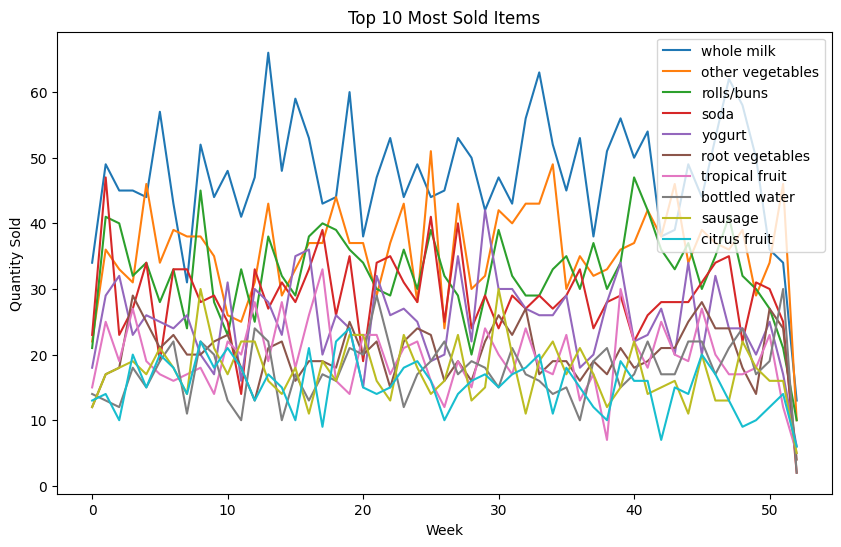

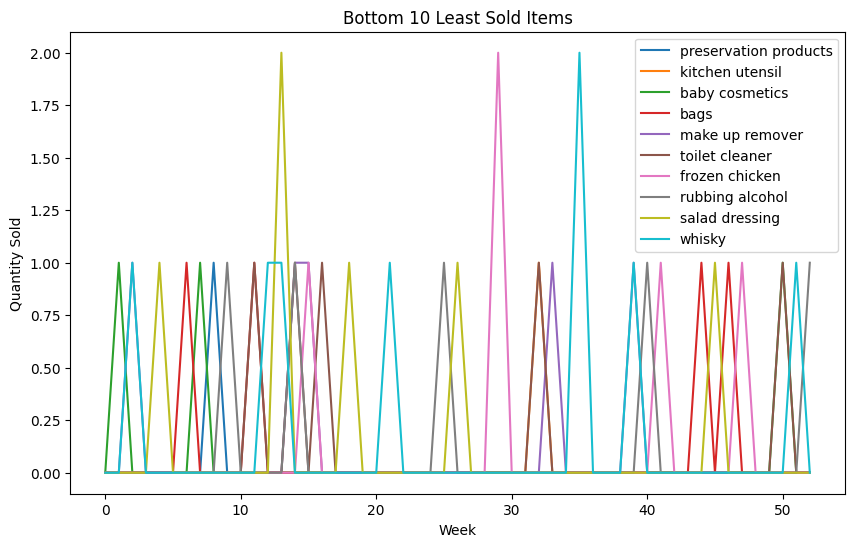

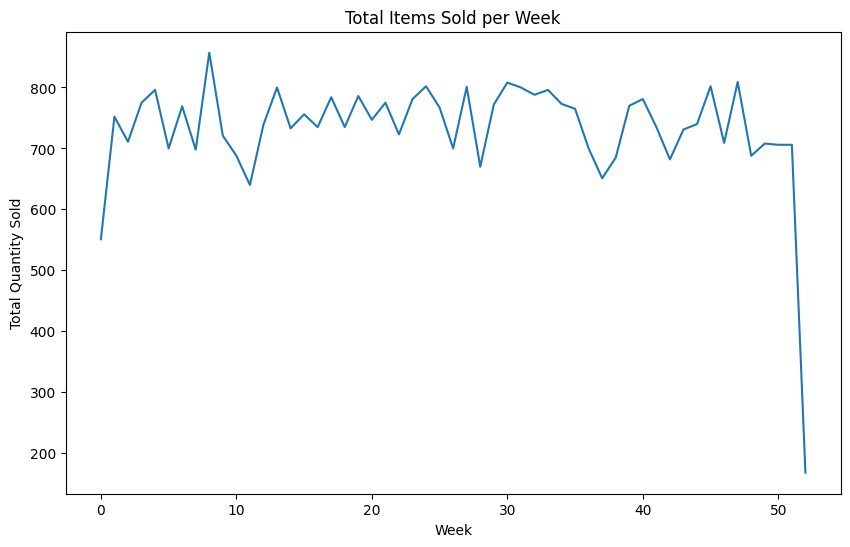

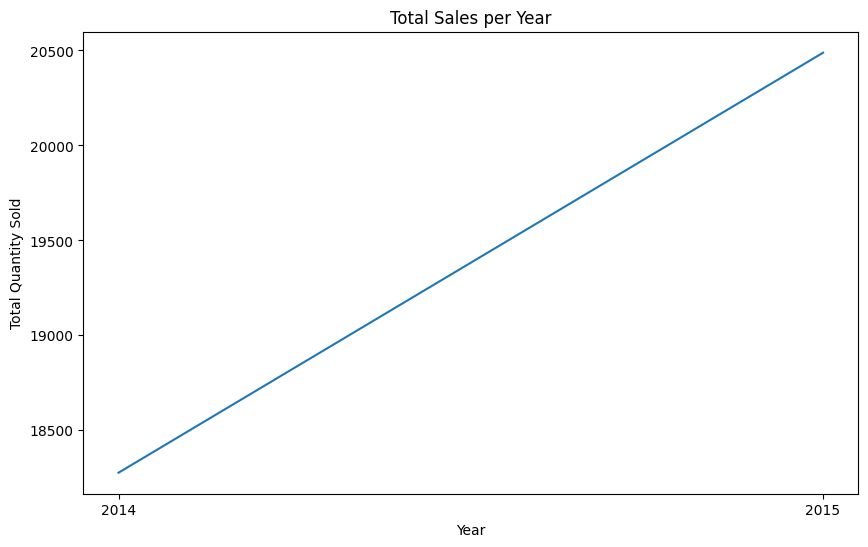

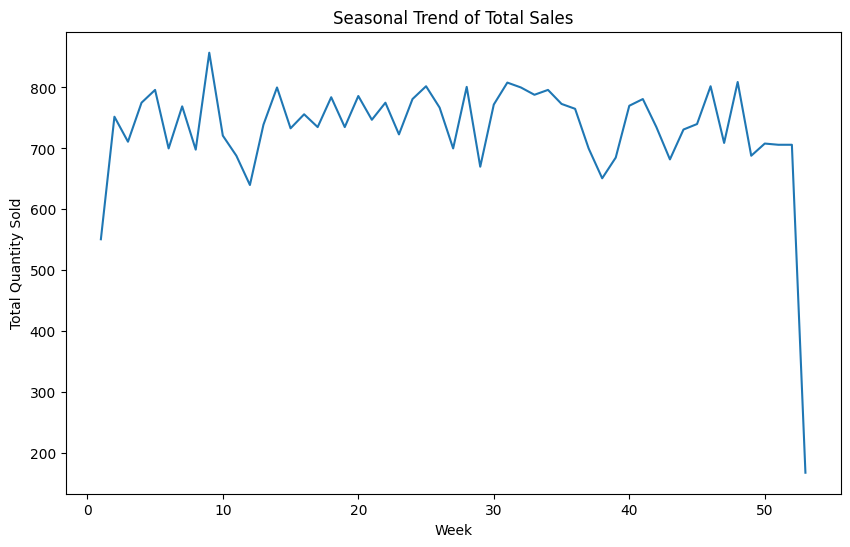

In [5]:
# 1. Pick the ten most sold items and plot them over the weeks
total_sales = sales_array.sum(axis=(0, 1))
top_ten_items = total_sales.argsort()[-10:][::-1]
top_ten_sales = sales_array[:, :, top_ten_items].sum(axis=0)

plt.figure(figsize=(10, 6))
for i, item_id in enumerate(top_ten_items):
    item_name = products_df.loc[products_df['product_id'] == item_id + 1, 'product_name'].values[0]
    plt.plot(top_ten_sales[:, i], label=item_name)
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.title('Top 10 Most Sold Items')
plt.legend()
plt.show()

# 2. Pick the ten least sold items and plot them over the weeks
bottom_ten_items = total_sales.argsort()[:10]
bottom_ten_sales = sales_array[:, :, bottom_ten_items].sum(axis=0)

plt.figure(figsize=(10, 6))
for i, item_id in enumerate(bottom_ten_items):
    item_name = products_df.loc[products_df['product_id'] == item_id + 1, 'product_name'].values[0]
    plt.plot(bottom_ten_sales[:, i], label=item_name)
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.title('Bottom 10 Least Sold Items')
plt.legend()
plt.show()

# 3. Plot all the items sold over the weeks
total_sales_per_week = sales_array.sum(axis=(0, 2))

plt.figure(figsize=(10, 6))
plt.plot(total_sales_per_week)
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.title('Total Items Sold per Week')
plt.show()

# Additional exploratory analysis 1: Plot the total sales per year
total_sales_per_year = sales_array.sum(axis=(1, 2))
years = range(sales_data['year'].min(), sales_data['year'].max() + 1)

plt.figure(figsize=(10, 6))
plt.plot(years, total_sales_per_year)
plt.xlabel('Year')
plt.ylabel('Total Quantity Sold')
plt.title('Total Sales per Year')
plt.xticks(years)
plt.show()

# Additional exploratory analysis 2: Plot the seasonal trend of total sales
weekly_sales = sales_array.sum(axis=(0, 2))
weeks = range(1, len(weekly_sales) + 1)

plt.figure(figsize=(10, 6))
plt.plot(weeks, weekly_sales)
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.title('Seasonal Trend of Total Sales')
plt.show()

We observe the following:

[COMPLETE]

We then train several models to see which is best.

In [35]:
# Load the sales data from the numpy array
sales_array = np.load('sales_array.npy')

trimmed_data = sales_array[:, 1:-1, :]

# Reshape the array to a 2D format
num_samples = sales_array.shape[0] * sales_array.shape[1]
num_features = sales_array.shape[2]
reshaped_data = sales_array.reshape((num_samples, num_features))

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(reshaped_data)

# Create a DataFrame from the reshaped data
data = pd.DataFrame(scaled_data)

"""
# Assuming the last column is the target variable (sales)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Split the data into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
"""

# Assuming the data is sorted chronologically
train_size = int(len(data) * 0.8)

# Split the data into train and test sets
train_data = data[:train_size]
test_data = data[train_size:]

# Split the train data into train and validation sets
train_size = int(len(train_data) * 0.8)
val_data = train_data[train_size:]
train_data = train_data[:train_size]

# Separate features and target variable for each set
X_train = train_data.to_numpy()
y_train = pd.concat([train_data.iloc[1:], train_data.iloc[:1]]).reset_index(drop=True).to_numpy()
X_val = val_data.to_numpy()
y_val = pd.concat([val_data.iloc[1:], val_data.iloc[:1]]).reset_index(drop=True).to_numpy()
X_test = test_data.to_numpy()
y_test = pd.concat([test_data.iloc[1:], test_data.iloc[:1]]).reset_index(drop=True).to_numpy()

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
print("Linear Regression R^2 Score:", lr_score)

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_score = rf_model.score(X_test, y_test)
print("Random Forest R^2 Score:", rf_score)

# XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_score = xgb_model.score(X_test, y_test)
print("XGBoost R^2 Score:", xgb_score)

# RNN
rnn_model = Sequential()
rnn_model.add(SimpleRNN(256, activation='relu', input_shape=(1, X_train.shape[1])))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dense(sales_array.shape[-1]))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_rnn = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
rnn_model.fit(X_train_rnn, y_train, validation_data=(X_val_rnn, y_val), epochs=50, batch_size=32)
rnn_score = rnn_model.evaluate(X_test_rnn, y_test)
print("RNN Mean Squared Error:", rnn_score)

# LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='relu', input_shape=(X_train.shape[1], 1)))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(sales_array.shape[-1]))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val_reshaped = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_model.fit(X_train_reshaped, y_train, validation_data=(X_val_reshaped, y_val), epochs=50, batch_size=32)
lstm_score = lstm_model.evaluate(X_test_reshaped, y_test)
print("LSTM Mean Squared Error:", lstm_score)

Linear Regression R^2 Score: -0.9981017506615912
Random Forest R^2 Score: -0.15533955861504445
XGBoost R^2 Score: -0.6429575482844548
Epoch 1/50


/opt/homebrew/Caskroom/miniconda/base/envs/cs4365/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1403 - val_loss: 0.1156
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1088 - val_loss: 0.0999
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0932 - val_loss: 0.0888
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0813 - val_loss: 0.0796
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0721 - val_loss: 0.0725
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0646 - val_loss: 0.0678
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0594 - val_loss: 0.0656
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0561 - val_loss: 0.0653
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0541 - val_loss: 0.0657
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0529 - val_loss: 0.0655
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0519 - val_loss: 0.0651
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0509 - val_loss: 0.0644
Epoch 13/50
3/3 ━━━━━

We can adjust it to use the previous three features to more realistically predict using timeseries and history

In [36]:
# LSTM with past 3 time steps
timesteps = 3

# Prepare the input data for LSTM
def create_dataset(X, y, timesteps):
    X_data, y_data = [], []
    for i in range(len(X) - timesteps):
        X_data.append(X[i:(i + timesteps), :])
        y_data.append(y[i + timesteps])
    return np.array(X_data), np.array(y_data)

X_train_step, y_train_step = create_dataset(X_train, y_train, timesteps)
X_val_step, y_val_step = create_dataset(X_val, y_val, timesteps)
X_test_step, y_test_step = create_dataset(X_test, y_test, timesteps)


print(X_train_step.shape)
lstm_model = Sequential()
lstm_model.add(LSTM(256, activation='relu', input_shape=(timesteps, X_train.shape[1])))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(sales_array.shape[-1]))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')


lstm_model.fit(X_train_step, y_train_step, validation_data=(X_val_step, y_val_step), epochs=50, batch_size=32)
lstm_score = lstm_model.evaluate(X_test_step, y_test_step)
print("LSTM Mean Squared Error:", lstm_score)

rnn_model = Sequential()
rnn_model.add(SimpleRNN(256, activation='relu', input_shape=(timesteps, X_train.shape[1])))
rnn_model.add(Dense(128, activation='relu'))
rnn_model.add(Dense(sales_array.shape[-1]))
rnn_model.compile(optimizer='adam', loss='mean_squared_error')

rnn_model.fit(X_train_step, y_train_step, validation_data=(X_val_step, y_val_step), epochs=50, batch_size=32)
rnn_score = rnn_model.evaluate(X_test_step, y_test_step)
print("RNN Mean Squared Error:", rnn_score)

(64, 3, 167)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.1303 - val_loss: 0.1214
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1171 - val_loss: 0.1097
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1069 - val_loss: 0.0982
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0954 - val_loss: 0.0876
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0839 - val_loss: 0.0785
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0764 - val_loss: 0.0719
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0691 - val_loss: 0.0667
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0630 - val_loss: 0.0635
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0599 - val_loss: 0.0614
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0566 - val_loss: 0.0599
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0548 - val_loss: 0.0597
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0547 - val_

Both models now perform more realistically and are able to use the previous three weeks data.

The RNN performs better so we will use that.

In [44]:
rnn_model.save('rnn_model.keras')

The next portion of the project is to get recent trends and incorporate it into demand forecasting.

In [11]:
SPOONACULAR_API_KEY = "fc8b842b8b3149f98b9afed693af6aa1"
BRAVE_API_KEY = "BSADtmC-nKi9ZSEhxeF-4Xui1ukH-AT"

In [12]:
spoonacular_client = API(SPOONACULAR_API_KEY)
pytrends = TrendReq()
brave = Brave(BRAVE_API_KEY)

In [13]:
def get_trending_recipes(timeframe="now 7-d"):
    """
    Retrieve rapidly rising recipe trends from Google Trends.
    
    Args:
        timeframe (str): The time range to analyze trends. Default is the past 7 days.
        
    Returns:
        list: A list of tuples containing the trending recipe keyword and its percentage change.
    """
    kw_list = ["recipe"]
    pytrends.build_payload(kw_list, cat=0, timeframe=timeframe, geo="US")
    related_queries = pytrends.related_queries()
    
    trending_recipes = []
    rising_trends = related_queries["recipe"]["rising"]
    for index, row in rising_trends.iterrows():
        keyword = row["query"]
        percentage_change = row["value"]
        trending_recipes.append((keyword, percentage_change))
        
    return trending_recipes

In [14]:
def get_recipe_ingredients(recipe_name):
    """
    Extract ingredients from a recipe using the Spoonacular API.
    
    Args:
        recipe_name (str): The name of the recipe.
        
    Returns:
        list: A list of ingredients for the recipe.
    """
    try:
        # Check if the recipe exists in Spoonacular
        search_response = spoonacular_client.search_recipes_complex(recipe_name)
        time.sleep(1)
        if search_response.json()["totalResults"] > 0:
            # If the recipe exists, retrieve its ingredients directly
            recipe_id = search_response.json()["results"][0]["id"]
            ingredients_response = spoonacular_client.get_analyzed_recipe_instructions(recipe_id)
            time.sleep(1)
            steps = ingredients_response.json()[0]["steps"]
            ingredients = []
            for step in steps:
                ingredients.extend(step["ingredients"])
            ingredient_names = [ingredient["name"] for ingredient in ingredients]
            return ingredient_names
        else:
            pass
            # If the recipe doesn't exist, search for a website with the recipe using Brave Search API
            search_query = f"{recipe_name} recipe"
            search_response = brave.search(q=search_query, count=10).web_results
            if len(search_response) > 0:
                recipe_url = search_response[0]["url"]
                
                # Extract ingredients from the recipe URL using Spoonacular
                response = spoonacular_client.extract_recipe_from_website(recipe_url)
                time.sleep(1)
                ingredients = response.json()["extendedIngredients"]
                ingredient_names = [ingredient["name"] for ingredient in ingredients]
                return ingredient_names
    except Exception as e:
        print(f"Error retrieving ingredients for {recipe_name}: {str(e)}")
        return []

In [15]:
def save_to_file(data, filename):
    """
    Save data to a JSON file.
    
    Args:
        data (list): The data to be saved.
        filename (str): The name of the file to save the data to.
    """
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)

In [16]:
recipe_data_file = "recipe_data.json"
if os.path.exists(recipe_data_file):
    with open(recipe_data_file) as f:
        recipe_data = json.load(f)
else:
    recipe_data = []
    # Get trending recipe keywords and their percentage change from Google Trends
    trending_recipes = get_trending_recipes()
    # Extract ingredients for each trending recipe
    for recipe, growth in trending_recipes:
        ingredients = get_recipe_ingredients(recipe)
        recipe_data.append({"name": recipe, "growth": growth, "ingredients": ingredients})

    # Save recipe data to a file
    save_to_file(recipe_data, recipe_data_file)

In [17]:
recipe_product_ingredients_file = "recipe_product_ingredients.json"
if not os.path.exists(recipe_product_ingredients_file):
    # Load recipe data from JSON file
    with open("recipe_data.json") as f:
        recipe_data = json.load(f)

    # Load products from CSV file using pandas
    products_df = pd.read_csv("products.csv")

    # Load the pre-trained sentence transformer model
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

    # Find the closest product for each ingredient and save with product ID
    recipe_product_ingredients = []
    for recipe in recipe_data:
        recipe_name = recipe["name"]
        recipe_growth = recipe["growth"]
        ingredients = recipe["ingredients"]
        product_ingredients = set()
        for ingredient in ingredients:
            ingredient_embedding = model.encode([ingredient])[0]
            product_embeddings = model.encode(products_df['product_name'].tolist())
            similarities = cosine_similarity([ingredient_embedding], product_embeddings)[0]
            closest_product_index = similarities.argmax()
            closest_product_id = int(products_df.iloc[closest_product_index]['product_id'])
            product_ingredients.add(closest_product_id)
        recipe_product_ingredients.append({
            "recipe": recipe_name,
            "growth": recipe_growth,
            "ingredients": list(product_ingredients)
        })

    # Save the recipes, their growth, and their ingredients as product IDs to a new file
    with open(recipe_product_ingredients_file, "w") as file:
        json.dump(recipe_product_ingredients, file, indent=4)
else:
    with open(recipe_product_ingredients_file) as file:
        recipe_product_ingredients = json.load(file)

The next and final part of the project is to use the model to predict inventory and incorporate price data

In [46]:

lstm_model = load_model('rnn_model.keras')

# Load the sales data from the numpy array
sales_array = np.load('sales_array.npy')
averaged = np.ceil(np.mean(sales_array, axis=0))
with open("recipe_data.json") as f:
    recipe_data = json.load(f)
input_data = averaged[:3]

scaler = MinMaxScaler()
input_data_scaled = scaler.fit_transform(input_data)
input_data_scaled = input_data_scaled.reshape((1, 3, input_data_scaled.shape[1]))

predicted_sales_scaled = lstm_model.predict(input_data_scaled)

# Scale the predicted sales back to the original scale
predicted_sales = scaler.inverse_transform(predicted_sales_scaled.reshape(1, -1))
predicted_sales = np.clip(predicted_sales, 0, None)

for recipe in recipe_product_ingredients:
    scale = (recipe["growth"] / 100) + 1
    idxs = np.array(recipe["ingredients"]) - 1
    predicted_sales[:, idxs] *= scale

predicted_sales = np.round(predicted_sales).astype(int)

print(predicted_sales)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[18 19  6 29 17  1  6  5  5  5  7  8  1  3  2  2 10 16  7  6  4  9  4  8
   7  3  5  2  2  0  0  1  2  3  2  4  1 25  0  2  2  0  1  6  6  0  0  0
   1  7  4  1  2  1  1  3  3  2  3 12  3  2  0  3  3  7  0  1 10  5  7  6
   4  6  5  3  0  2  0  4  2  2  5  0  1  1  0  0  1  0  1  1  0  0  1  2
   0  1  0  1  0  0  2  3  0  0  0  0  1  0  0  0  1  2  5  1  0  0  3  0
   1  1  0  0  1  1  1  1  0  0  2  0  0  0  0  3  0  2  0  0  0  1  0  0
   0  0  0  0  0  1  0  1  0  1  0  1  0  1  1  0  0  0  0  0  0  0  0]]


In [47]:
combined_sales = np.vstack((input_data, predicted_sales))
reshaped_combined_sales = combined_sales[np.newaxis, :, :]
print(reshaped_combined_sales)


[[[ 8. 17.  5. 11. 11.  3.  7.  4.  4.  2.  6.  3.  1.  4.  2.  1.  7.
    9.  6.  5.  4.  6.  2.  7.  5.  2.  3.  0.  2.  1.  1.  2.  2.  1.
    1.  2.  2. 12.  0.  1.  1.  0.  0.  7.  6.  0.  0.  1.  1.  4.  4.
    0.  3.  0.  1.  2.  2.  1.  3.  2.  1.  1.  0.  3.  2.  2.  0.  1.
    5.  5.  6.  1.  3.  6.  4.  2.  1.  2.  1.  3.  2.  1.  4.  0.  1.
    1.  0.  0.  1.  0.  0.  1.  0.  1.  0.  1.  0.  1.  0.  2.  0.  1.
    2.  3.  0.  0.  1.  0.  0.  1.  0.  0.  0.  2.  3.  1.  0.  1.  2.
    0.  1.  1.  1.  0.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  2.
    0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.
    1.  1.  1.  0.  2.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [13. 25.  7. 18. 21.  2.  7.  5.  6.  5.  6.  3.  1.  3.  2.  3.  7.
   15.  9.  5.  4.  9.  5.  8. 11.  4.  4.  2.  3.  1.  0.  1.  0.  1.
    4.  2.  2. 24.  1.  2.  2.  1.  1.  5.  5.  0.  1.  0.  1.  6.  3.
    1.  2.  2.  1.  3.  3.  3.  1.  3.  1.  1.  1.  2.  4.  2.  0.  1.
    7.  3.  6.  2

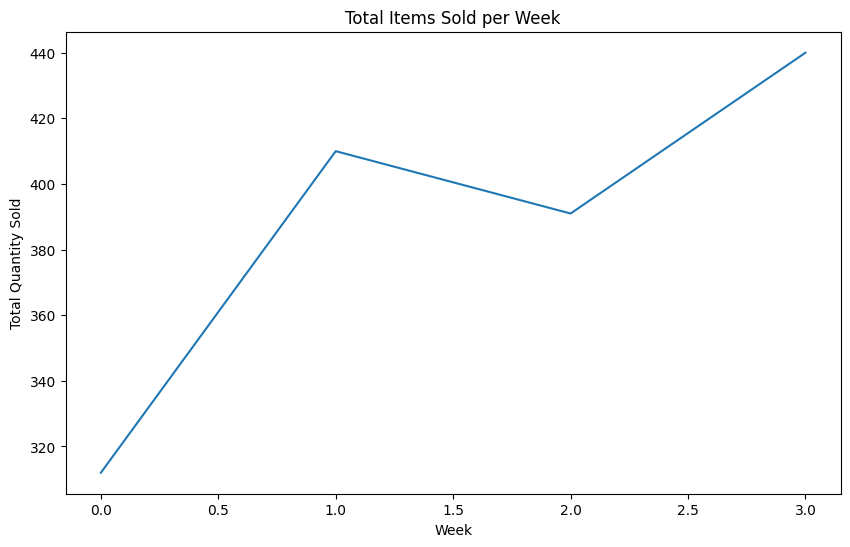

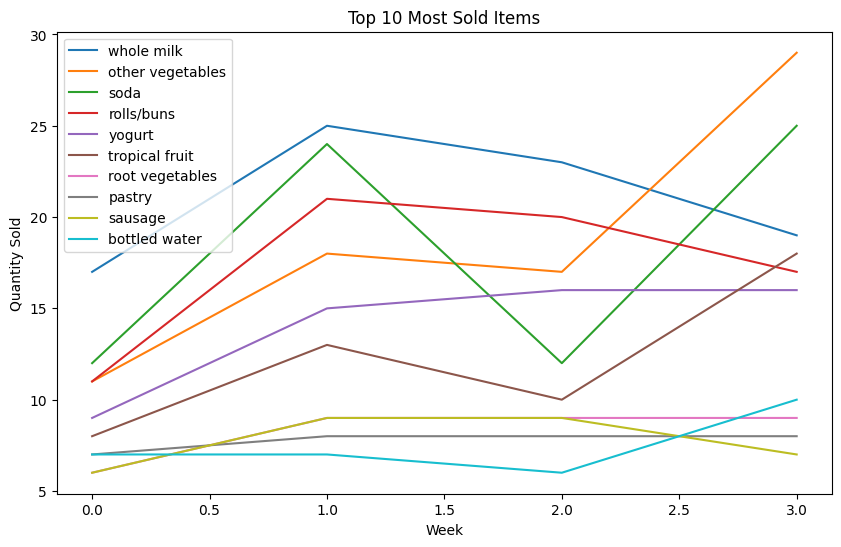

In [48]:
# 3. Plot all the items sold over the weeks
total_sales_per_week = reshaped_combined_sales.sum(axis=(0, 2))

plt.figure(figsize=(10, 6))
plt.plot(total_sales_per_week)
plt.xlabel('Week')
plt.ylabel('Total Quantity Sold')
plt.title('Total Items Sold per Week')
plt.show()

# 1. Pick the ten most sold items and plot them over the weeks
total_sales = reshaped_combined_sales.sum(axis=(0, 1))
top_ten_items = total_sales.argsort()[-10:][::-1]
top_ten_sales = reshaped_combined_sales[:, :, top_ten_items].sum(axis=0)

plt.figure(figsize=(10, 6))
for i, item_id in enumerate(top_ten_items):
    item_name = products_df.loc[products_df['product_id'] == item_id + 1, 'product_name'].values[0]
    plt.plot(top_ten_sales[:, i], label=item_name)
plt.xlabel('Week')
plt.ylabel('Quantity Sold')
plt.title('Top 10 Most Sold Items')
plt.legend()
plt.show()